# Imports and setup

In [104]:
# !pip install pyspark

In [105]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd

In [106]:
spark = SparkSession.builder.appName('egypt_hotels_spark_session').getOrCreate()
spark

# Read CSV data and understanding the data


In [107]:
df = spark.read.option('header', 'true').csv('/content/egphotelbookings.csv', inferSchema=True)
df.show(1)

+---+-----------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+
|_c0|            hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_requests|
+---+-----------------+-----------+-

In [108]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: integer (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true

In [109]:
df.count()

7326

we have 7326 records

# Preprocessing and Cleaning

In [110]:
from pyspark.sql.functions import col, isnan, when, count

# check for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).head()

Row(_c0=0, hotel=0, is_canceled=0, lead_time=0, arrival_date_year=0, arrival_date_month=0, arrival_date_week_number=0, arrival_date_day_of_month=0, stays_in_weekend_nights=0, stays_in_week_nights=0, adults=0, children=0, babies=0, meal=0, country=3, distribution_channel=0, is_repeated_guest=0, previous_cancellations=0, previous_bookings_not_canceled=0, reserved_room_type=0, assigned_room_type=0, booking_changes=0, deposit_type=0, agent=1156, company=6921, days_in_waiting_list=0, customer_type=0, adr=0, required_car_parking_spaces=0, total_of_special_requests=0)

In [111]:
# get percentage of missing values
print(f'Country: {3/df.count():.2f}')
print(f'agent: {1156/df.count():.2f}')
print(f'company: {6921/df.count():.2f}')

Country: 0.00
agent: 0.16
company: 0.94


Looks like Country is missing at only a 3 records so we can easily just remove the corresponding rows

In [112]:
df = df.na.drop(how='any', subset=['Country'])

The agent column, however seems to be about 16% of the entire dataset so it definitely deserves some more investigating

After some further investigating we now know that the agent field respresents the ID of the travel agency that made the booking

If it's null this will most likely mean that the booking was made in person.


In [113]:
df = df.na.drop(how='any', subset=['agent'])

Now the company column is something different altogether. It's missing values represent almost 94% of the entire dataset. If we can't find a proper solution for handeling this we'll most probably need to remove that column.

It's now clear that the company field just represents the ID of the company entity that made the booking or responsible
for paying the booking. ID is presented instead of designation for

Knowing that, I think it's safe to say that the missing values can just be interpreted as booking that were not made or payed by a company so we can just drop it

In [114]:
df = df.drop('company')

Now let's quickly check the missing values again to make sure there's no oversight

In [115]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).head()

Row(_c0=0, hotel=0, is_canceled=0, lead_time=0, arrival_date_year=0, arrival_date_month=0, arrival_date_week_number=0, arrival_date_day_of_month=0, stays_in_weekend_nights=0, stays_in_week_nights=0, adults=0, children=0, babies=0, meal=0, country=0, distribution_channel=0, is_repeated_guest=0, previous_cancellations=0, previous_bookings_not_canceled=0, reserved_room_type=0, assigned_room_type=0, booking_changes=0, deposit_type=0, agent=0, days_in_waiting_list=0, customer_type=0, adr=0, required_car_parking_spaces=0, total_of_special_requests=0)

# Let's just map out questiions that we would like to answer

## agent -> which agent makes the most bookings to assign them to more important clients


## Average Daily Rate by Month


## Ditributions of booking over the months for one year

#  Derive 3 insights about attributes from the dataset using appropriate visualizations

To do this we need to have a look at our variables and state not only which ones could actually be useful but also if thay can be visualized to show insights

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt


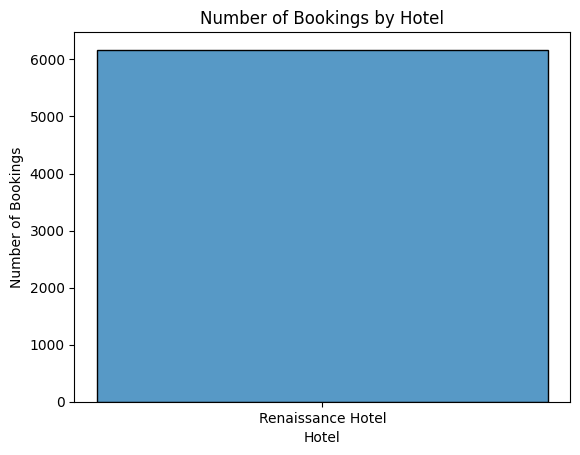

In [117]:
from pyspark.sql.functions import count

hotel_counts = df.toPandas()

sns.histplot(hotel_counts['hotel'])

plt.title('Number of Bookings by Hotel')
plt.xlabel('Hotel')
plt.ylabel('Number of Bookings')

plt.show()

Hmmm... Seems the dataset only incudes one hotel

## agent -> which agent makes the most bookings to assign them to more important clients

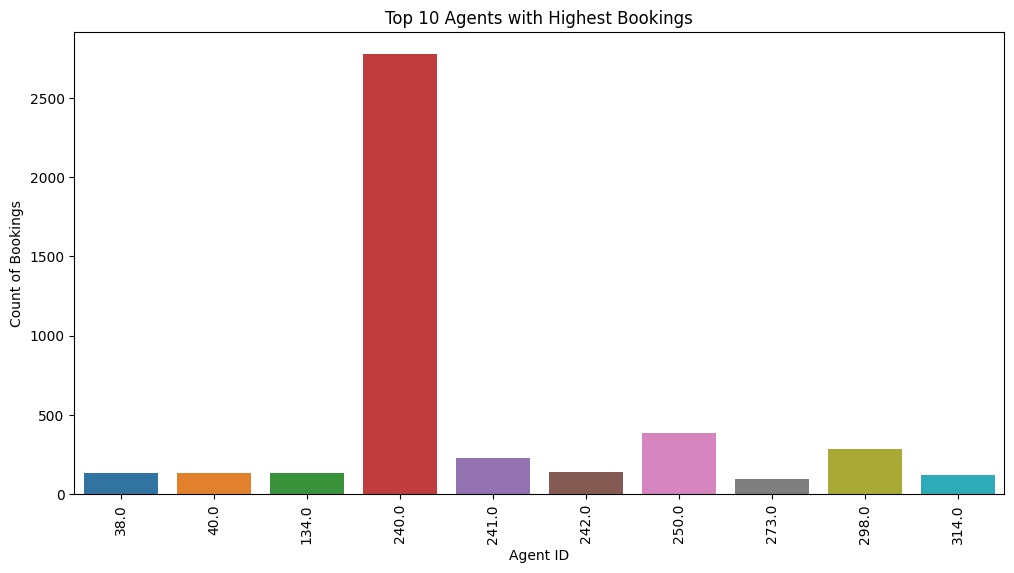

In [118]:
agent_counts = df.groupby('agent').count().toPandas()

top_agents = agent_counts.nlargest(10, 'count')

plt.figure(figsize=(12, 6))
sns.barplot(x='agent', y='count', data=top_agents)
plt.xlabel('Agent ID')
plt.ylabel('Count of Bookings')
plt.title('Top 10 Agents with Highest Bookings')
plt.xticks(rotation=90)
plt.show()


## Average Daily Rate by Month

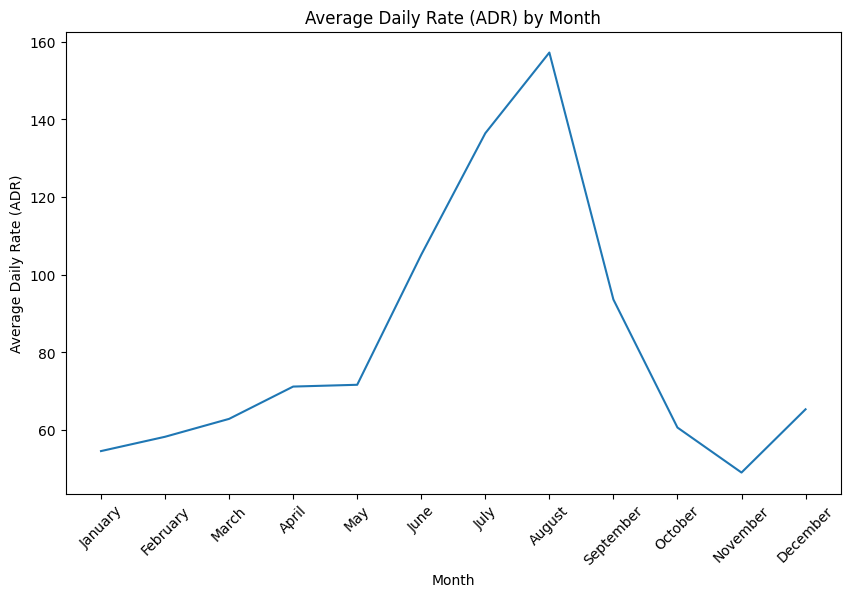

In [119]:
adr_by_month = df.groupby('arrival_date_month').avg('adr').toPandas()

months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                'August', 'September', 'October', 'November', 'December']
adr_by_month['arrival_date_month'] = pd.Categorical(adr_by_month['arrival_date_month'], categories=months_order, ordered=True)
adr_by_month = adr_by_month.sort_values('arrival_date_month')

plt.figure(figsize=(10, 6))
sns.lineplot(x='arrival_date_month', y='avg(adr)', data=adr_by_month)
plt.xlabel('Month')
plt.ylabel('Average Daily Rate (ADR)')
plt.title('Average Daily Rate (ADR) by Month')
plt.xticks(rotation=45)
plt.show()


## Ditributions of booking over the months for one year

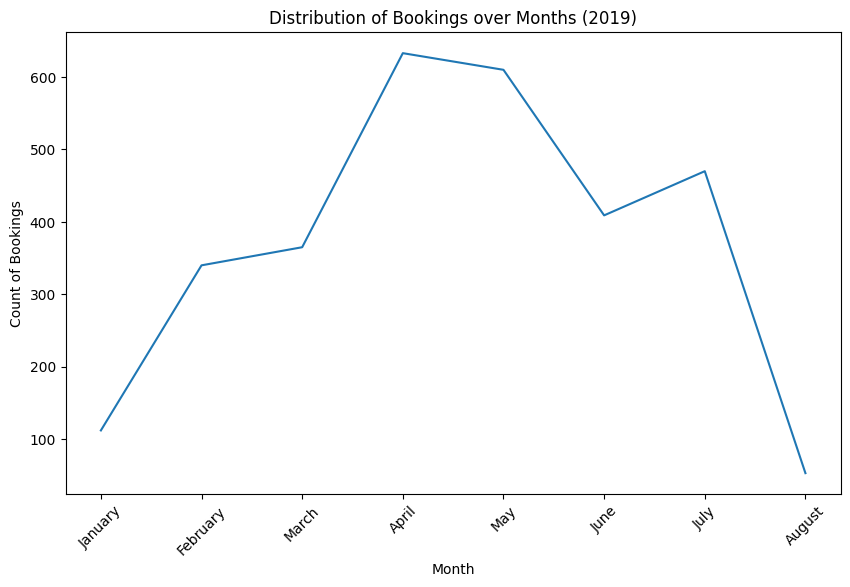

In [120]:
bookings_one_year = df.filter(df.arrival_date_year == 2019)

bookings_by_month = bookings_one_year.groupby('arrival_date_month').count().toPandas()

months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
                'August', 'September', 'October', 'November', 'December']
bookings_by_month['arrival_date_month'] = pd.Categorical(bookings_by_month['arrival_date_month'], categories=months_order, ordered=True)
bookings_by_month = bookings_by_month.sort_values('arrival_date_month')

plt.figure(figsize=(10, 6))
sns.lineplot(x='arrival_date_month', y='count', data=bookings_by_month)
plt.xlabel('Month')
plt.ylabel('Count of Bookings')
plt.title('Distribution of Bookings over Months (2019)')
plt.xticks(rotation=45)
plt.show()


# Come up with 3 promotions to offer per hotel (must be supported by results of queries of your own creation)


In [121]:
pd.read_csv('/content/egphotelbookings.csv')['hotel'].value_counts()
# it's only Renaissance Hotel

Renaissance Hotel    7326
Name: hotel, dtype: int64

## We can offer family packages for the month of july because it has the bookings with the most babies

In [122]:
from pyspark.sql.functions import month, sum

top_month_babies = df.groupBy('arrival_date_month').agg(sum('babies').alias('total_babies'))

top_month = top_month_babies.sort('total_babies', ascending=False).first()['arrival_date_month']

print("Top Month for Babies: ", top_month)


Top Month for Babies:  July


## We can offer promotions to people that want to book for more than four nights

In [123]:
from pyspark.sql.functions import col, avg

df_with_total_nights = df.withColumn('total_nights', col('stays_in_week_nights') + col('stays_in_weekend_nights'))

average_nights_stayed = df_with_total_nights.select(avg('total_nights')).collect()[0][0]

print("Average Nights Stayed: ", int(average_nights_stayed))


Average Nights Stayed:  4


## We can offer a romance honeymoon package for july

In [124]:
from pyspark.sql.functions import month, sum

adults_only_df = df.filter(df.babies == 0)

top_month_adults = adults_only_df.groupBy('arrival_date_month').agg(sum('adults').alias('total_adults'))

top_month = top_month_adults.sort('total_adults', ascending=False).first()['arrival_date_month']

print("Top Month for Adults (No Babies): ", top_month)


Top Month for Adults (No Babies):  July


# Using SparkML, produce at least 3 models to predict whether a booking will be canceled or not

## Preprocess

In [125]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, LinearSVC,  NaiveBayes
from sklearn.metrics import accuracy_score

In [126]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: integer (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true

In [131]:
columns_to_index = ['hotel', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', ]

indexer_stages = []

for column in columns_to_index:
    indexer = StringIndexer(inputCol=column, outputCol=column + '_indexed')
    indexer_stages.append(indexer)

pipeline = Pipeline(stages=indexer_stages)
pipeline_model = pipeline.fit(df)

df_indexed = pipeline_model.transform(df)

df_indexed.show()

+---+-----------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+--------------------+-------------+------+---------------------------+-------------------------+-------------+------------+---------------+----------------------------+--------------------------+--------------------------+--------------------+---------------------+
|_c0|            hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_c

In [133]:
column_types = df_indexed.dtypes

independant_columns = [column[0] for column in column_types if column[1] in ('int', 'bigint', 'float', 'double')]

independant_columns.remove('_c0')
independant_columns.remove('agent')
independant_columns.remove('arrival_date_year')
independant_columns.remove('arrival_date_week_number')
independant_columns.remove('hotel_indexed')
independant_columns.remove('previous_cancellations')


df_feat = df_indexed.select(independant_columns)
df_feat.show()

+-----------+---------+-------------------------+-----------------------+--------------------+------+--------+------+-----------------+------------------------------+---------------+--------------------+------+---------------------------+-------------------------+------------+---------------+----------------------------+--------------------------+--------------------------+--------------------+---------------------+
|is_canceled|lead_time|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|is_repeated_guest|previous_bookings_not_canceled|booking_changes|days_in_waiting_list|   adr|required_car_parking_spaces|total_of_special_requests|meal_indexed|country_indexed|distribution_channel_indexed|reserved_room_type_indexed|assigned_room_type_indexed|deposit_type_indexed|customer_type_indexed|
+-----------+---------+-------------------------+-----------------------+--------------------+------+--------+------+-----------------+-------------------------

In [136]:
important_features = df_feat.columns
important_features.remove('is_canceled')
important_features

['lead_time',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'meal_indexed',
 'country_indexed',
 'distribution_channel_indexed',
 'reserved_room_type_indexed',
 'assigned_room_type_indexed',
 'deposit_type_indexed',
 'customer_type_indexed']

In [137]:
featurizationPipeline = Pipeline(stages = [VectorAssembler(inputCols=important_features, outputCol="features")])

featurizationPipelineModel = featurizationPipeline.fit(df_feat)
df_with_features = featurizationPipelineModel.transform(df_feat)
df_with_features.show()

+-----------+---------+-------------------------+-----------------------+--------------------+------+--------+------+-----------------+------------------------------+---------------+--------------------+------+---------------------------+-------------------------+------------+---------------+----------------------------+--------------------------+--------------------------+--------------------+---------------------+--------------------+
|is_canceled|lead_time|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|is_repeated_guest|previous_bookings_not_canceled|booking_changes|days_in_waiting_list|   adr|required_car_parking_spaces|total_of_special_requests|meal_indexed|country_indexed|distribution_channel_indexed|reserved_room_type_indexed|assigned_room_type_indexed|deposit_type_indexed|customer_type_indexed|            features|
+-----------+---------+-------------------------+-----------------------+--------------------+------+--------+------+-

In [141]:
train, test = df_with_features.randomSplit([0.8, 0.2])

# Models and evaluation

# LogisticRegression

In [145]:
lg = LogisticRegression(featuresCol="features", labelCol="is_canceled")
lg = lg.fit(train)

pred = lg.transform(test)

true_labels=test.select('is_canceled')
lr_predictions=pred.select('prediction')

accuracy = accuracy_score(true_labels.toPandas(), lr_predictions.toPandas())
print("Logistic Regression Accuracy =",accuracy * 100,"%")

Logistic Regression Accuracy = 77.18446601941747 %


# SVM classifier

In [146]:
svm = LinearSVC(featuresCol="features", labelCol="is_canceled")
svm = svm.fit(train)

pred = svm.transform(test)

true_labels=pred.select('is_canceled')
lr_predictions=pred.select('prediction')

accuracy = accuracy_score(true_labels.toPandas(), lr_predictions.toPandas())
print("LinearSVC Accuracy =",accuracy*100,"%")

LinearSVC Accuracy = 78.31715210355988 %


# Naive Bayes

In [147]:
nb = NaiveBayes(featuresCol="features", labelCol="is_canceled")
nb = nb.fit(train)

pred = nb.transform(test)

true_labels=pred.select('is_canceled')
lr_predictions=pred.select('prediction')

accuracy = accuracy_score(true_labels.toPandas(), lr_predictions.toPandas())
print("NaiveBayes Accuracy =",accuracy*100,"%")

NaiveBayes Accuracy = 73.05825242718447 %
